<a href="https://www.kaggle.com/code/ailafelixa/pharma-sales-exploratory-data-analysis?scriptVersionId=125080237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


### Descrição dos dados ###
[Descrição completa e fonte podem ser encontradas aqui](https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data) 

The dataset is built from the initial dataset consisted of 600000 transactional data collected in 6 years (period 2014-2019), indicating date and time of sale, pharmaceutical drug brand name and sold quantity, exported from Point-of-Sale system in the individual pharmacy. Selected group of drugs from the dataset (57 drugs) is classified to the following Anatomical Therapeutic Chemical (ATC) Classification System categories:

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides

N05B - Psycholeptics drugs, Anxiolytic drugs

N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

R03 - Drugs for obstructive airway diseases

R06 - Antihistamines for systemic use

____________________________________________________

### **Nosso objetivo é avaliar a venda de diferentes medicamentos, de modo a conseguir capturar alguns insigths importantes como:**
### 
#### *1.Quais classes de medicamentos apresentaram aumento ou diminuição de demanda entre 2014 e 2019?* ####

#### *2. Quais os meses com mais e menos vendas?* ####

#### *3. Quais as classes de medicamentos mais e menos vendidos por mês?* ####

#### *4. Existe correlação entre a venda mensal de determinadas classes de medicamentos?* ####

## Importação e pré-processamento ##

In [2]:
#Primeiro, vamos importar e checar a estrutura dos dados
pharma_sales_data = pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')
pharma_sales_data.head()
#pharma_sales_data.tail()

#Podemos notar que os dados já estão ordenados pela data e que a coleta dos dados ocorre no último dia de cada mês.
#Vamos ver em qual formato os dados estão armazenados
pharma_sales_data.dtypes

#A coluna de data está com tipo 'object', mas para trabalharmos com as datas corretamente devemos converte-la para o tipo datetime64
pharma_sales_data['datum'] = pd.to_datetime(pharma_sales_data['datum'], format='%Y-%m-%d')
pharma_sales_data.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
dtype: object

In [3]:
#Vamos verificar também algumas informações relevantes sobre o nosso dataset, como por exemplo o número de linhas, número de colunas e quantidade de valores nulos
pharma_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   datum   70 non-null     datetime64[ns]
 1   M01AB   70 non-null     float64       
 2   M01AE   70 non-null     float64       
 3   N02BA   70 non-null     float64       
 4   N02BE   70 non-null     float64       
 5   N05B    70 non-null     float64       
 6   N05C    70 non-null     float64       
 7   R03     70 non-null     float64       
 8   R06     70 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 5.0 KB


Como podemos ver, nosso dataset tem 70 linhas e 9 colunas e não possui valores nulos. Agora podemos começa a responder as nossas perguntas.

### 1. Quais classes de medicamentos apresentaram aumento ou diminuição de demanda entre 2014 e 2019? ##

In [4]:
#Primeiro vamos selecionar os dados referentes aos anos de 2014 (nosso start-point) e de 2019 (nosso end-point)
df_1 = pharma_sales_data.loc[(pharma_sales_data.datum.dt.year == 2014) | (pharma_sales_data.datum.dt.year == 2019)]
df_1.loc[:,'datum'] = df_1.datum.dt.year
df_1 = df_1.groupby('datum').sum() #Calculando a quantidade de vendas para cada classe de medicamento em cada ano
df_1.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014,1510.77,1333.594,1683.279,10094.555,4355.0,303.0,1277.0,828.30
2019,1517.27,1117.221,879.800,8011.616,2405.6,196.0,2050.0,1073.57


In [5]:
#Vamos calcular o delta (diferença no número de unidades vendidas no ano de 2019 menos o número de unidades vendidas no ano de 2014)
delta = df_1.diff()
delta = delta.reset_index()
delta = delta.loc[delta.datum == 2019]
delta = delta.drop(columns='datum')
delta = round(delta)
delta_str = delta.applymap(str) #Gerando um dataframe de strings para auxiliar na legenda dos gráficos

In [6]:
#Vamos calcular também a proporção de crescimento ou decréscimo comparando 2019 com 2014
proporcao = df_1.iloc[1]/df_1.iloc[0]
proporcao = pd.DataFrame(proporcao)
proporcao = proporcao.rename(columns={0:'proporcao'})
proporcao = round(proporcao,2) #arredondando os valores para duas casas decimais apenas

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

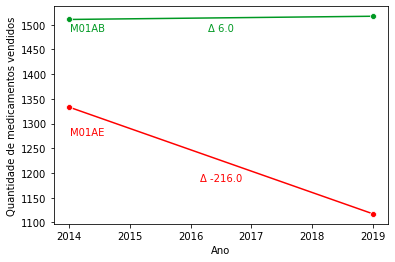

In [7]:
# Vamos comparar o desempenho de medicamentos com ATC similares, começando pelos anti-inflamatórios
ax = sns.lineplot(x=df_1.index, y=df_1.M01AB, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.9, df_1.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
bx = sns.lineplot(x=df_1.index, y=df_1.M01AE, ci = None, marker='o', color='red')
plt.text(0.1, 0.42, df_1.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
plt.text(0.5, 0.21, 'Δ '+delta_str.iloc[0,1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
ax.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso dos medicamentos anti-inflamatórios e antireumáticos, aqueles derivados de ácido acético manteram um nível aproximadamente constante de vendas entre o primeiro e o último ano da análise. Já os medicamentos da mesma classe, mas derivados de ácido propiônico tiveram uma queda acentuada. 

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

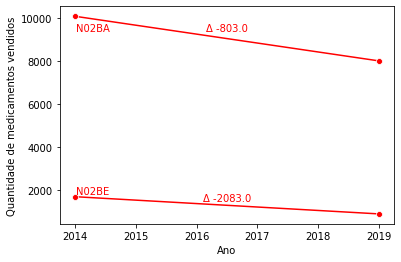

In [8]:
#Outros analgésicos e anti-piréticos
cx = sns.lineplot(x=df_1.index, y=df_1.N02BA, ci = None, marker='o', color='red')
plt.text(0.1, 0.90, df_1.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
dx = sns.lineplot(x=df_1.index, y=df_1.N02BE, ci = None, marker='o', color='red')
plt.text(0.1, 0.15, df_1.columns[3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
plt.text(0.5, 0.12, 'Δ '+delta_str.iloc[0,3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
cx.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso de outros analgésicos e anti-piréticos, a queda foi ainda mais acentuada, principalmente para medicamentos da classe N02BE

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

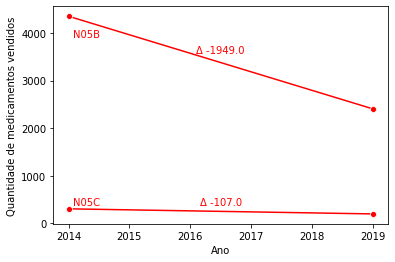

In [9]:
#Psicolépticos
ex=sns.lineplot(x=df_1.index, y=df_1.N05B, ci = None, marker='o', color='red')
plt.text(0.1, 0.87, df_1.columns[4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
plt.text(0.5, 0.80, 'Δ '+delta_str.iloc[0,4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
fx=sns.lineplot(x=df_1.index, y=df_1.N05C, ci = None, marker='o', color='red')
plt.text(0.1, 0.1, df_1.columns[5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
plt.text(0.5, 0.1, 'Δ '+delta_str.iloc[0,5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
ex.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

No caso dos psicolépticos também houve diminuição nas vendas das duas classes, com destaque para a classe N05B que vendeu quase 2000 unidades a menos em 2019 quando comparado a 2014

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

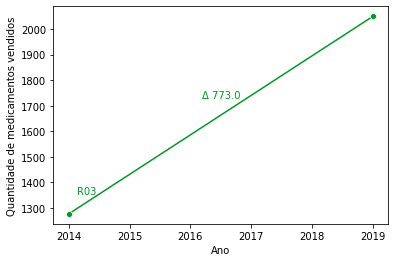

In [10]:
#Fármacos para o tratamento de doenças pulmonares obstrutivas
r1x = sns.lineplot(x=df_1.index, y=df_1.R03, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
r1x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

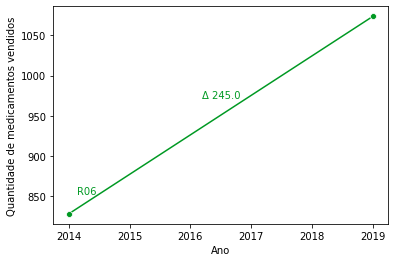

In [11]:
#Anti-histamínicos
r2x = sns.lineplot(x=df_1.index, y=df_1.R06, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
r2x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

Por fim, os fármacos das classes R03 e R06 ambos apresentaram crescimento nas vendas quando compara-se o primeiro e o último ano de análise

[Text(0, 0.5, 'Proporção de vendas (2019/2014)')]

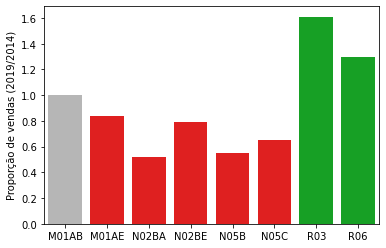

In [12]:
#Agora vamos visualizar os dados juntos para termos uma noção global do crescimento e decréscimo proporcional para cada medicamento
#Para não ter que definir manualmente todas as cores, vamos elaborar uma paleta de cores de forma condicional
cores_prop = ['red' if num < 1 else '#00B713' if num > 1 else '#B6B6B6' for num in proporcao.proporcao]
bp = sns.barplot(x=proporcao.index, y=proporcao.proporcao, palette=cores_prop)
bp.set(ylabel='Proporção de vendas (2019/2014)')


Fazemos uma comparação nas proporções, vemos que:
* Fármacos da classe M01AB mantiveram as vendas aproximadamente constantes nos dois pontos de medida
* Fármacos das classes R03 e R06 aumentaram as vendas em quase 2x em 2019 quando comparado a 2014
* O restante dos fármacos tiveram resultados piores em 2019 do que em 2014, com destaque para o N02BA que vendeu quase 50% a menos em 2019 do que em 2014. 

In [13]:
#Vamos analisar agora a performance de M01AB, N02BA e R03 considerando todos os anos que temos dispoíveis para tentar entender o que pode ter acontecido nesses três casos
#onde respectivamente não tivemos crescimento, tivemos decréscimo de vendas e tivemos aumento de vendas entre o start-point e o end-point

df_1b = pharma_sales_data.loc[:,['datum','M01AB','N02BA','R03']]
df_1b.loc[:,'datum'] = df_1b.datum.dt.year
df_1b = df_1b.groupby('datum').sum() #Calculando a quantidade de vendas para cada classe de medicamento em cada ano
df_1b

,M01AB,N02BA,R03
datum,,,
2014,1510.77,1683.279,1277.00
2015,1905.62,1608.630,1776.25
2016,2125.06,1664.800,2137.00
2017,1653.79,1091.150,1732.00
2018,1786.93,1123.800,2765.00
2019,1517.27,879.800,2050.00


Text(0.05, 0.2, 'R03')

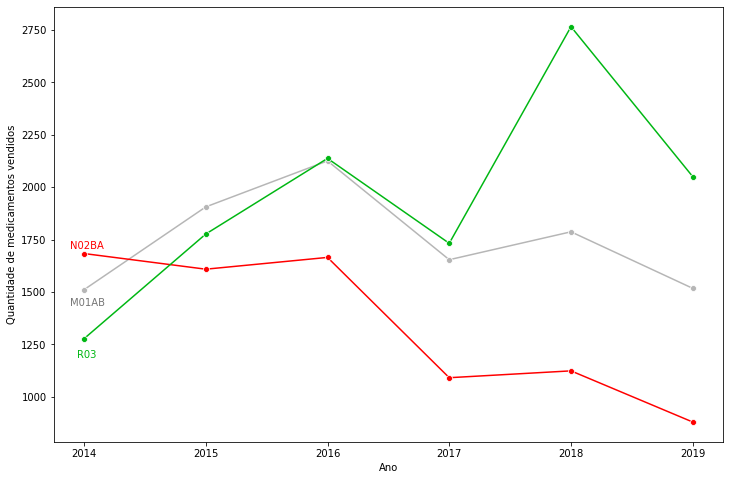

In [14]:
#Vamos manter o mesmo código de cores utilizados na visualização das proporções para facilitar a intepretação do gráfico
m01ab = sns.lineplot(x=df_1b.index, y=df_1b.M01AB, ci = None, marker='o', color='#B6B6B6')
plt.text(0.05, 0.32, df_1b.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=m01ab.transAxes, color='#757575')
m01ab.figure.set_size_inches(12, 8)
m01ab.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

n02ba = sns.lineplot(x=df_1b.index, y=df_1b.N02BA, ci = None, marker='o', color='red')
plt.text(0.05, 0.45, df_1b.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=n02ba.transAxes, color='red')

r03 = sns.lineplot(x=df_1b.index, y=df_1b.R03, ci = None, marker='o', color='#00B713')
plt.text(0.05, 0.20, df_1b.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=r03.transAxes, color='#00B713')

### Existem alguns pontos interessantes que podem ser destacados ao analisar esse gráfico para cada uma das três classes de medicamentos ###
* **Os medicamentos da classe M01AB tiveram um acentuado crescimento de vendas entre 2014 e 2016, onde as vendas começaram a declinar.**
    * Apesar de uma pequena recuperação ter acontecido entre 2017 e 2018, os medicamentos dessa classe, no último ponto de análise, tiveram uma performance muito similar ao visto em 2014
    * Assim, apesar de na análise de proporção as vendas parecerem constantes, na verdade elas estão em queda. Isso ressalta a importância de se analisar o histórico inteiro, visto que delinear ações de contenção ou de reversão para vendas em queda podem exigir diferentes abordagens do que ações direcionadas para impulsionar vendas estagnadas
    
    
* **As vendas de medicamentos da classe dos N02BA decresceram desde 2014, tendo uma diminuição mais acentuada entre 2016 e 2017 e atingindo o seu menor nível em 2019.**

* **Os medicamentos da classe R03, usados para tratamento de doenças obstrutivas das vias aéres, tiveram um grande crescimento entre 2014 e 2018, atingindo seu maior nível nesse ano**
    * Apesar disso, houve uma queda acentuada de vendas entre 2018 e 2019; a presença dessa informação também permite uma tomada de decisão mais alinhada com a realidade do número de vendas

É interessante observar que houve quedas nas vendas das três classes de medicamentos entre 2018 e 2019. Seria interessante analisar quais fatores internos (por exemplo questões financeiras, reestruturações, etc) e externos (mudanças econômicas, de regulamentação, epidemiológicas, etc.) poderiam ter influenciado nesses resultados. 


### 2. Quais os meses com mais e menos vendas? ###

In [15]:
#Para responder a essa pergunta vamos começar novamente tratando nossos dados para que fiquem da forma que precisamos
#Para isso criaremos uma amostra dos dados agrupados por mês, independente do ano
df_2 = deepcopy(pharma_sales_data)
df_2.loc[:,'month'] = df_2.datum.dt.month
df_2 = df_2.groupby('month').mean() #calculando a média de vendas por mês
df_2 = round(df_2,2)
df_2

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
month,,,,,,,,
1,124.54,114.94,111.07,1032.26,265.03,22.00,178.04,39.58
2,137.44,127.63,127.48,993.83,248.40,15.17,195.17,46.73
3,152.28,123.14,123.81,927.92,256.23,19.33,204.17,98.72
4,153.54,107.70,112.32,776.82,239.90,15.50,184.50,141.12
5,150.23,113.14,115.19,714.66,235.30,18.83,163.33,155.09
6,141.44,107.04,115.95,624.25,242.50,17.67,130.50,133.11
7,164.58,117.02,107.98,610.26,257.27,14.83,91.67,104.12
8,169.95,112.36,107.79,654.82,281.67,19.00,96.17,83.38
9,150.15,119.10,102.89,960.86,277.22,15.67,138.67,77.20


In [16]:
#Vamos criar uma segunda amostra contendo mês e ano para verificar se existem peculiaridades associadas ao mês e ano
df_2y = deepcopy(pharma_sales_data)
df_2y.loc[:,'year'] = df_2y.datum.dt.year
df_2y.loc[:,'month'] = df_2y.datum.dt.month
df_2y = df_2y.drop('datum', axis=1)
df_2y

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month
0,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20,2014,1
1,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20,2014,2
2,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40,2014,3
3,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70,2014,4
4,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70,2014,5
...,...,...,...,...,...,...,...,...,...,...
65,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04,2019,6
66,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20,2019,7
67,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30,2019,8
68,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10,2019,9


Text(0.12, 0.51, 'Média geral')

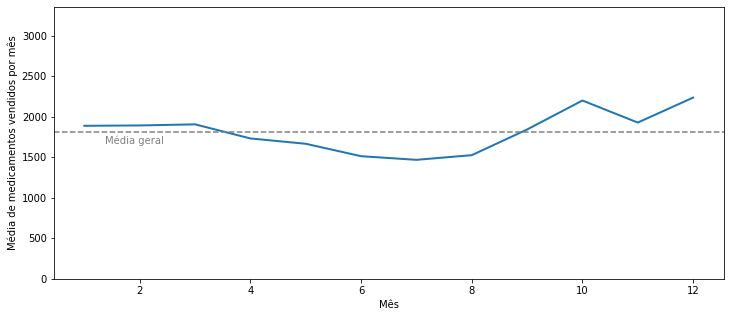

In [17]:
#Vamos verificar como a média de vendas se comporta ao longo dos meses, independentemente do produto 
df_2a = df_2.sum(axis=1)
df_2a = pd.DataFrame(df_2a)
df_2a = df_2a.rename(columns={0:'total'})
 
df2ax = sns.lineplot(x = df_2a.index, y=df_2a.total, **{'lw':'2'})
df2ax.figure.set_size_inches(12, 5)
df2ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2a.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.text(0.12, 0.51, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df2ax.transAxes, color='grey')

Podemos observar que as vendas ficam abaixo da média de abril a setembro e atingem seu maior volume nos meses de outubro e dezembro. Portanto, existe uma sazonalidade na venda dessas classes de fármacos, o que deve ser mantido em consideração ao fazer o planejamento de produção, logística e ações de marketing.

Text(0.5, 1.0, '2019')

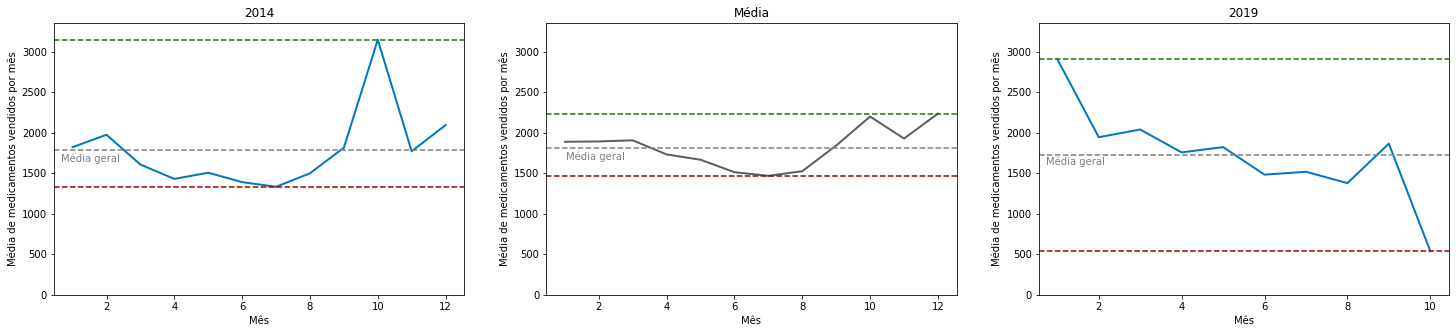

In [18]:
### Vamos analisar agora se essa tendência média se repete nos anos de 2014 (nosso start-point) e 2019 (nosso end-point)
df_2y2014 = df_2y.loc[df_2y['year']==2014]
df_2y2014 = df_2y2014.drop('year', axis=1)
df_2y2014 = df_2y2014.set_index('month')
df_2y2014 = df_2y2014.sum(axis=1)

df_2y2014 = pd.DataFrame(df_2y2014)
df_2y2014 = df_2y2014.rename(columns={0:'total'})

plt.subplots(figsize=(25, 5)) 
plt.subplot(1, 3, 1) 
df_2y2014ax = sns.lineplot(x = df_2y2014.index, y=df_2y2014.total, color='#0077C0',**{'lw':'2'})
#df_2y2014ax.figure.set_size_inches(5, 5)
df_2y2014ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2y2014.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2y2014.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2y2014.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.09, 0.50, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df_2y2014ax.transAxes, color='grey')
plt.title('2014')

plt.subplot(1, 3, 2) 
df2ax = sns.lineplot(x = df_2a.index, y=df_2a.total, color='#5C5E5F', **{'lw':'2'})
#df2ax.figure.set_size_inches(5, 5)
df2ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2a.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2a.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2a.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.12, 0.51, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df2ax.transAxes, color='grey')
plt.title('Média')


df_2y2019 = df_2y.loc[df_2y['year']==2019]
df_2y2019 = df_2y2019.drop('year', axis=1)
df_2y2019 = df_2y2019.set_index('month')
df_2y2019 = df_2y2019.sum(axis=1)

df_2y2019 = pd.DataFrame(df_2y2019)
df_2y2019 = df_2y2019.rename(columns={0:'total'})

plt.subplot(1, 3, 3) 
df_2y2019ax = sns.lineplot(x = df_2y2019.index, y=df_2y2019.total, color='#0077C0',**{'lw':'2'})
#df_2y2014ax.figure.set_size_inches(5, 5)
df_2y2019ax.set(xlabel='Mês', ylabel='Média de medicamentos vendidos por mês')
plt.ylim(0, df_2a['total'].max()*1.5)
plt.axhline(df_2y2019.total.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.axhline(df_2y2019.total.max(),xmin=0, xmax=1, color='#1C7A00', **{'ls':'--'})
plt.axhline(df_2y2019.total.min(),xmin=0, xmax=1, color='#9C0000', **{'ls':'--'})
plt.text(0.09, 0.49, 'Média geral', horizontalalignment='center',
     verticalalignment='center', transform=df_2y2019ax.transAxes, color='grey')
plt.title('2019')

O ano de 2014 teve um padrão mais parecido com a média, onde os meses de abril a novembro tiveram vendas abaixo da média, havendo uma recuperação para a média após agosto e atingindo o patamar máximo de vendas em outubro. Em 2014 entretanto o pico de vendas foi bem mais acentuado que a média. 

Em 2019 podemos observar um padrão completamente diferente. O ano se inicia com um pico de vendas bem maior que a média, mas as vendas apresentam uma queda acentuada. As vendas também ficam abaixo da média entre maio e setembro, mas ao invés da recuperação acentuada que antes era observada entre setembro e outubro houve novamente uma queda acentuada, chegando ao menor patamar em outubro de 2019. Para esse ano os dados de novembro e dezembro não estão disponíveis, e por isso não é possível saber se houve algum tipo de recuperação ou se as vendas foram ainda mais baixas nos meses seguintes. 

**A partir desses dados podem surgir algumas questões importantes a serem debatidas do ponto de vista de gestão:**
1. O que faz com que as vendas fiquem abaixo da média entre aproximadamente abril a agosto/setembro? Existem estratégias que podem ser empregadas para melhoras esse cenário?


2. Similarmente, o que faz com que em geral outubro seja o melhor mês de vendas? Existe algo que é feito ao redor desse mês que possa ser aplicado em outras épocas do ano para termos melhores resultados?


3. Quais fatores foram os responsáveis por janeiro e outubro de 2019 terem sido tão peculiares quando comparado ao resultado médio geral?

Analisar esses fatores pode ser interessante para definir novas estratégias de negócio e montar planos de ação para contenção de danos e impulsionamento de vendas

### 3. Quais os medicamentos mais e menos vendidos por mês? ##

In [19]:
#Vamos utilizar a amostra do dataset que fizemos no tópico anterior
df_2['total'] = df_2.sum(axis=1)
df_2

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,total
month,,,,,,,,,
1,124.54,114.94,111.07,1032.26,265.03,22.00,178.04,39.58,1887.46
2,137.44,127.63,127.48,993.83,248.40,15.17,195.17,46.73,1891.85
3,152.28,123.14,123.81,927.92,256.23,19.33,204.17,98.72,1905.60
4,153.54,107.70,112.32,776.82,239.90,15.50,184.50,141.12,1731.40
5,150.23,113.14,115.19,714.66,235.30,18.83,163.33,155.09,1665.77
6,141.44,107.04,115.95,624.25,242.50,17.67,130.50,133.11,1512.46
7,164.58,117.02,107.98,610.26,257.27,14.83,91.67,104.12,1467.73
8,169.95,112.36,107.79,654.82,281.67,19.00,96.17,83.38,1525.14
9,150.15,119.10,102.89,960.86,277.22,15.67,138.67,77.20,1841.76


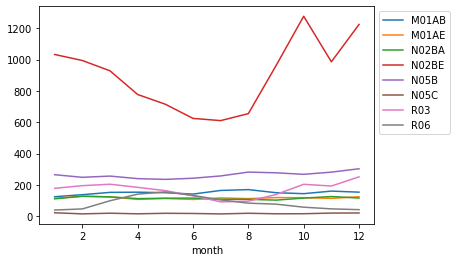

In [20]:
#Vamos plotar a nossa amostra em um gráfico simples pra verificar visualmente os medicamentos mais e menos vendidos por mês
mx = df_2[['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']].plot()
mx.legend(bbox_to_anchor=(1, 1))

Como podemos observar, a classe de medicamentos mais vendida em todos os meses foram os "outros analgésicos e anti-piréticos (pirazolonas e anilideos)" (N02BE). A classe menos vendida, também independentemente do mês, foram os N05C (psicolépticos, hipnóticos e sedativos). Isso pode acontecer devido ao fato do uso de analgésicos serem muito mais comuns e não necessitarem de receita médica na maioria dos casos, o que torna a auto-medicação mais frequente.

[Text(0.5, 0, 'Mês'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

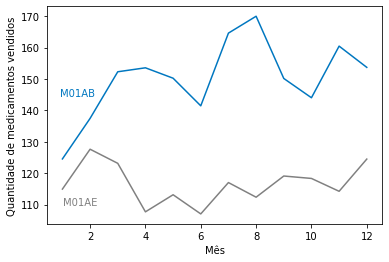

In [21]:
#Vamos agora comparar as classes de medicamentos de categorias ATC similares ao longo dos meses, novamente começando pelos anti-inflamatórios
mx1 = sns.lineplot(x=df_2.index, y=df_2.M01AB, ci = None, color='#0077C0')
plt.text(0.09, 0.6, df_2.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=mx1.transAxes, color='#0077C0')

mx2 = sns.lineplot(x=df_2.index, y=df_2.M01AE, ci = None, color='grey')
plt.text(0.1, 0.1, df_2.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=mx2.transAxes,color='grey')

mx1.set(xlabel='Mês', ylabel='Quantidade de medicamentos vendidos')

Ambas as classes de medicamentos possuem flutuações nas vendas ao longo dos meses do ano, mas as vendas da classe M01AB são maiores que as da classe M01AE durante todo o ano. Apesar do número de vendas das duas categorias não serem tão discrepantes em janeiro, a partir desse mês a classe M01AB apresenta um crescimento de vendas bem acentuado até o fim do pimeiro trimestre. Um crescimento similar é visto entre junho e agosto, onde a quantidade de vendas atinge seu valor máximo. Por outro lado, as vendas dos medicamentos da classe M01AE apresentam uma variação menos acentuada, se mantendo aproximadamente na mesma faixa de vendas durante todo ano. 
Isso indica que mesmo medicamentos de classes similares possuem uma demanda distinta ao longo do ano. Desse modo, também são necessárias estratégias distintas para lidar com os dois tipos de demanda.

[Text(0.5, 0, 'Mês'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

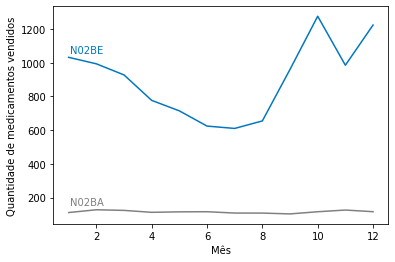

In [22]:
#Outros analgésicos e anti-piréticos
mx3 = sns.lineplot(x=df_2.index, y=df_2.N02BA, ci = None, color='grey')
plt.text(0.1, 0.1, df_2.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=mx3.transAxes, color='grey')

mx4 = sns.lineplot(x=df_2.index, y=df_2.N02BE, ci = None, color='#0077C0')
plt.text(0.1, 0.8, df_2.columns[3], horizontalalignment='center',
     verticalalignment='center', transform=mx4.transAxes, color='#0077C0')

mx3.set(xlabel='Mês', ylabel='Quantidade de medicamentos vendidos')

A classe N02BE é a mais vendida de todas as classes em todos os meses e apresenta um crescimento de vendas expressivo ao redor do mês de agosto, atingindo seu valor máximo em outubro. Apesar disso, na maior parte do ano as vendas desse medicamento apresentam queda quando comparadas ao mês anterior.
Para a classe N02BA as vendas são baixas, porém constantes, sem variações bruscas ao longo do ano.
Assim como no exemplo acima, o conhecimento dessas tendências permite um melhor planejamento e alocação de recursos de acordo com o objetivo da organização.

[Text(0.5, 0, 'Mês'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

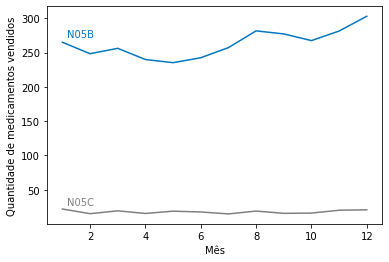

In [23]:
#Psicolépticos
mx5=sns.lineplot(x=df_2.index, y=df_2.N05B, ci = None, color='#0077C0')
plt.text(0.1, 0.87, df_2.columns[4], horizontalalignment='center',
     verticalalignment='center', transform=mx5.transAxes, color='#0077C0')

mx6=sns.lineplot(x=df_2.index, y=df_2.N05C, ci = None, color='grey')
plt.text(0.1, 0.1, df_2.columns[5], horizontalalignment='center',
     verticalalignment='center', transform=mx6.transAxes, color='grey')

mx5.set(xlabel='Mês', ylabel='Quantidade de medicamentos vendidos')

Similarmente a classe N02BA, a classe N05C também apresenta um volume baixo de vendas em todos os meses, porém mantém esse volume constante ao longo de todo o ano. A classe N05B apresenta mais vendas porém também não apresenta flutuações bruscas na demanda mensal, se mantendo aproximadamente no mesmo patamar de vendas independente da época do ano.

In [24]:
#Vamos por fim analisar se a tendência de vendas mensal para as classes de medicamentos mais e menos vendidas.
#Para isso, vamos novamente analisar novamente nosso start-point e nosso end-point

df_2yb = deepcopy(df_2y)
df_2yb = df_2yb.loc[:,['N02BE', 'N05C', 'month', 'year']]
df_2yb = df_2yb.loc[(df_2yb.year==2014) | (df_2yb.year==2019)]
df_2yb

,N02BE,N05C,month,year
0,878.030,50.0,1,2014
1,1001.900,31.0,2,2014
2,779.275,20.0,3,2014
3,698.500,18.0,4,2014
4,628.780,23.0,5,2014
5,548.225,23.0,6,2014
6,491.900,21.0,7,2014
7,583.850,29.0,8,2014
8,887.820,14.0,9,2014
9,1856.815,30.0,10,2014


Text(0.5, 1.0, 'N0BE')

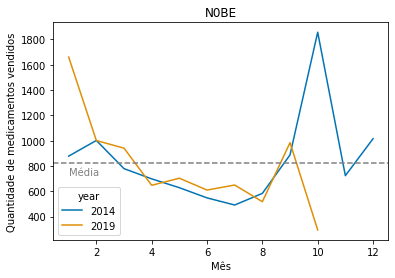

In [25]:
#Abaixo analisaremos a classe de fármacos mais vendida ao longo dos meses, a N02BE
yx1 = sns.lineplot(x='month', y='N02BE', data=df_2yb, hue='year', palette='colorblind')
#plt.text(0.09, 0.6, df_2yb.columns[0], horizontalalignment='center',
     #verticalalignment='center', transform=yx1.transAxes, color='#0077C0')
yx1.set(xlabel='Mês', ylabel='Quantidade de medicamentos vendidos')
plt.axhline(df_2yb.N02BE.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.text(0.09, 0.31, 'Média', horizontalalignment='center',
     verticalalignment='center', transform=yx1.transAxes, color='grey')
plt.title('N0BE')

A tendência ao longo dos meses variou bastante entre os anos e seguiu uma tendência parecida à observada no tópico 2, onde o ano de 2019 apresentou uma queda acentuada logo no início do ano e uma segunda queda acentuada em outubro. Em 2014 também tivemos uma tendência similar ao tópico anterior, com os meses de alta girando em torno de setembro e outubro e os meses de baixa de abril a agosto. Apesar das quedas bruscas em 2019, na maior parte dos meses as vendas dessa classe de medicamentos foi maior em 2019 do que em 2014. 

Text(0.5, 1.0, 'N05C')

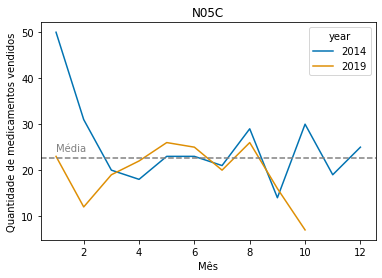

In [26]:
yx2 = sns.lineplot(x='month', y='N05C', data=df_2yb, hue='year', palette='colorblind')
yx2.set(xlabel='Mês', ylabel='Quantidade de medicamentos vendidos')
plt.axhline(df_2yb.N05C.mean(),xmin=0, xmax=1, color='grey', **{'ls':'--'})
plt.text(0.09, 0.42, 'Média', horizontalalignment='center',
     verticalalignment='center', transform=yx2.transAxes, color='grey')
plt.title('N05C')

Para a classe de medicamento menos vendida ao longo dos meses, não houve uma mudança brusca na média de medicamentos vendidos entre um ano e outro. Entretanto, nesse caso também é possível observar a queda de vendas no mês de outubro. Além disso, em 2014 a queda de vendas no início do ano foi bem mais acentuada. Em 2019 as vendas de abril a julho foram maiores do que nos outros meses, contrastando com dados da média geral dos medicamentos observada no tópico anterior.

#### *4. Existe correlação entre a venda mensal de determinadas classes de medicamentos?* ####

<AxesSubplot:>

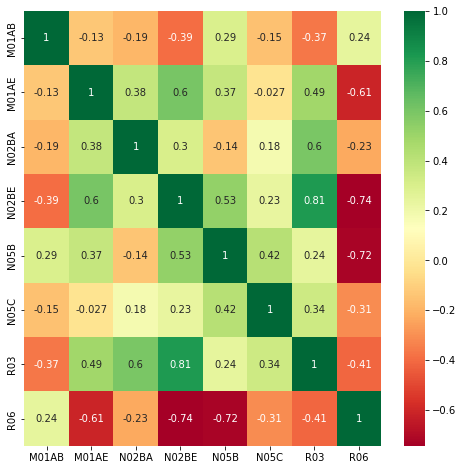

In [27]:
#Para analisar se existe uma correlação entre a venda mensal das classes de medicamentos vamos recorrer ao heatmap para valores de correlação
plt.figure(figsize=(8, 8))
sns.heatmap(df_2.drop('total',axis=1).corr(), annot=True, cmap="RdYlGn")

Nessa análise, valores mais próximos de 1 indicam uma forte correlação positiva e valores mais próximos de -1 indicam uma forte correlação negativa antre as classes em questão. Podemos obsevar que a classe R06 possui uma correlação negativa relativamente forte com as classes N02BE e N05B, indicando que o volume de vendas dos medicamentos dessas classes em geral se movem em direções opostas (quando um é alto os outros geralmente são baixos e vice-versa). Já medicamentos da classe RO3 possuem uma correlação positiva forte com medicamentos da classe dos N02BE, indicando que as vendas dessas categorias geralmente caminham em direções similares (quando uma aumenta a outra também aumenta e vice-versa). Isso pode ser um indicativo de que essas duas classes podem possuir dinâmicas de uso parecidas ou até mesmo serem empregadas em conjunto dependendo da situação clínica do paciente.

## Conclusões ##


O dataset utilizado possui relativamente poucos dados, entretanto foi possível retirar insights importantes como por exemplo
* Tendências da demanda de cada classe de medicamento ao longo dos anos
* Flutuações no volume de vendas ao longo dos meses e mudanças na dinâmica do volume de vendas mensais ao longo dos anos
* Comportamento de vendas de cada classe de medicamento específica ao longo dos meses do ano
* Correlações entre as diferentes classes de medicamento

Esses dados podem auxiliar no planejamento de análises mais aprofundadas e direcionadas para um objetivo específico e também podem servir como ponto de partida, por exemplo, para a criação de modelos de inteligência artificial que auxiliem a predizer o volume de vendas de determinado fármaco. 